In [1]:

import numpy as np, pandas as pd
from shapely import *
from pcbflow import *
#skidl requires imp (https://integrativemodeling.org/)
from skidl import *
import beampipe_parameters

In [270]:

import os
path = "pcb"
# Check whether the specified path exists or not
isExist = os.path.exists(path)
if not isExist:
   # Create a new directory because it does not exist
   os.makedirs(path)

In [2]:
beampipe0=beampipe_parameters.Beampipe()
#def layer_boundaries(layer=0, side="L", beampipe=beampipe0, height=59.8, width=59.6,gap=0.4):
def layer_boundaries(layer=0, side="L", beampipe=beampipe0, height=60.96, width=60.96,gap=0.4):
    offsetX=-10
    holeX=beampipe.holeX(layer)
    holeR=beampipe.holeR(layer)
    if side=="R":
        offsetX-width/2
        
        phi= np.linspace(-np.pi/2, np.pi/2, 25)
        
        x,y = [offsetX-width/2, offsetX-width/2, -gap/2, -gap/2] + list(holeX-holeR*np.cos(phi)) + [-gap/2,-gap/2, -39.8], \
                 [-height/2,height/2, height/2, holeR]+ list(-holeR*np.sin(phi))+ [-holeR,-height/2, -height/2]
        return Polygon(zip(x,y))
    if side=="L":
        
        phi0 = np.arccos((holeX-gap/2)/holeR)
        #print((np.pi-phi0)/np.pi*2)
        phi = np.linspace(phi0,2*np.pi-phi0, 13)
        
        x=[offsetX+width/2, offsetX+width/2, gap/2] + list(holeX-np.cos(phi)*holeR) + [gap/2, 19.8]
        y=[-height/2,height/2, height/2]+list(holeR*np.sin(phi)) + [-height/2, -height/2]
        return Polygon(zip(x,y))

In [68]:
def convert(x,y):
    height,width=609.6, 609.6
    return -np.array(x)*10+width/2-100,np.array(y)*10+height/2

In [167]:
from pcbflow import *

def make_board(layer, side):
    bounds=layer_boundaries(layer, side)
    height,width=609.6, 609.6
    brd = Board((width, height))
    #brd.add_outline()
    x,y=bounds.exterior.xy
    
    x,y=convert(x,y)
    brd.layers["GML"].lines.append(LinearRing(zip(x,y)))
    brd.add_inner_copper_layer(4)
    brd.body()
    
    return brd
# fill the top and bottom copper layers and merge nets named "GND"
#brd.fill_layer("GTL", "GND")
#brd.fill_layer("GBL", "GND")

# save the PCB asset files
brd = make_board(0,"L")
brd.save("mypcb")

Rendering Gerber GTD...
Rendering Gerber GTP...
Rendering Gerber GTO...
Rendering Gerber GTS...
Rendering Gerber GTL...
Rendering Gerber GBL...
Rendering Gerber GBS...
Rendering Gerber GBO...
Rendering Gerber GBP...
Rendering Gerber GBD...
Rendering Gerber GML...
Rendering Gerber GP2...
Rendering Gerber GP3...
Rendering Gerber GP4...
Rendering Gerber GP5...
Rendering excellon drill files...
Rendering preview_top.['pdf']...
Rendering preview_top_docu.['pdf']...
Rendering preview_bot.['pdf']...
Rendering preview_bot_docu.['pdf']...
Rendering preview_all.['pdf']...


In [382]:
#contains the SiPM, LED, silkscreen, 
class ReadoutModule(PCBPart):
    def __init__(self, *args, **kwargs):
        self.family = "U"
        self.footprint = "SOT23"
        self.vias=[]
        super().__init__(*args, **kwargs)
        
    #modified from the "chamfered" routine
    def square(self, dc, w, h):
        dc.push()
        dc.forward(h / 2)
        dc.left(90)
        dc.forward(w / 2)
        dc.right(180)
        dc.newpath()
        for e in (w, h, w, h):
            dc.forward(e)
            dc.right(90)
        dc.silk(side=self.side)
        dc.pop()
    
    def draw_x(self, dc, a):
        for s in (-1, 1):
            dc.push()
            dc.forward(a / 2)
            dc.left(90*s)
            dc.forward(a / 2)
            dc.right(180+45*s)
            dc.newpath()

            dc.forward(a*np.sqrt(2))
            dc.silk(side=self.side)
            dc.pop()
            
    
    def place(self, dc):
        #draw square for the sensitive part of the SiPM
        self.square(dc, 1.3, 1.3)
        #now add pads
        x,y,w,h=-1.2725, -0.55, 0.7, 0.7
        self.smd_pad(dc.copy().goxy(x, y).rect(w, h))
        self.smd_pad(dc.copy().goxy(x, -y).rect(w, h))
        x=0.7525
        self.smd_pad(dc.copy().goxy(x, y).rect(w, h))
        self.smd_pad(dc.copy().goxy(x, -y).rect(w, h))
        [p.set_name(nm) for p, nm in zip(self.pads, ("SIPM_AN", "SIPM_CAT", "3", "4"))] 
        
        #now add the pads for the LED
        x,y,w,h=0.875,1.885, 1.05, 0.95
        self.smd_pad(dc.copy().goxy(x, y).rect(w, h))
        self.pads[-1].set_name("LED_AN")
        x=-0.875
        self.smd_pad(dc.copy().goxy(x, y).rect(w, h))
        self.pads[-1].set_name("LED_CAT")
        
        
        #now add the x's for the fiducials
        for y in -2, 0, 2:
            self.draw_x(dc.copy().goxy(4,y), 0.5)
            
        #now fill the silkscreen and add a dipole symbol for the LED
        
        dc.board.add_bitmap(dc.xy, "png/silkscreen_for_dimple_and_LED.png", scale=0.4)


In [383]:
def outline_polygon(brd, xy):
    dc=brd.DC(xy[0])
    dc.push()
    dc.newpath()
    olddir=90
    for j in range(len(xy)-1):
        #help(dc.goto)    
        t=xy[j+1][1]-xy[j][1],xy[j+1][0]-xy[j][0]
        newdir=180/np.pi*np.arctan2(*t)
        dc.left(newdir-olddir)
        dc.forward(np.hypot(xy[j+1][1]-xy[j][1],xy[j+1][0]-xy[j][0]))
        olddir=newdir
    dc.silk('top')
    dc.pop()

In [384]:
def determine_connector_numbers(df): 
    connector_numbers=[]
    n=0
    for i in range(len(df)):
        if not df.deadzone[i]:
            connector_numbers.append(n)
            n+=1
        else :
            connector_numbers.append(-1) #deadzone cell
    
    #now use the reverse numbers on the top half:
    connector_numbers[len(df)//2:] = np.max(connector_numbers)-connector_numbers[len(df)//2:]
        
    
    df['connector_number'] = connector_numbers

In [385]:
import pickle
with open("all_layers.pkl", "rb") as file:
    all_layers=pickle.load(file)
with open("summary.pkl", "rb") as file:
    summary=pickle.load(file)

In [392]:


def make_board(layer, side):
    #convert everything from cm to mm
    cm=10
    bounds=layer_boundaries(layer, side)
    height,width=60.96, 60.96
    brd = Board((width*cm, height*cm))
    
    #create the outline of the board
    x,y=bounds.exterior.xy
    x,y=convert(x,y)
    brd.layers["GML"].lines.append(LinearRing(zip(x,y)))
    
    # change the design rules so that the vias and their pads are small enough not to short the traces together
    # TODO check if these modified values are reasonable
    brd.drc.via_drill=0.3 # default=0.5 mm (diameter)
    brd.drc.via_annular_ring=0.1 #default = 8 mil (0.2 mm for people who prefer to use units that make sense)
    
    
    brd.add_inner_copper_layer(4)
    brd.body()
    

    df=all_layers[(layer, side)]

    determine_connector_numbers(df)

    readouts=[]
    maxrow=np.max(df.query("deadzone==0")['row'])
    maxcol=np.max(df.query("deadzone==0")['col'])
    
    
    for i in range(len(df)):
        if df.deadzone[i]:
            continue
        center=convert(df.x[i], df.y[i])

        ro=brd.add_part(center, ReadoutModule)
        # add the row and column number
        brd.add_text((center[0], center[1]+6), f"{df.row[i]},{df.col[i]}")

        # draw the cell boundaries
        xy=[convert(df.boundsx[i][j],df.boundsy[i][j]) for j in range(len(df.boundsy[i]))]
        outline_polygon(brd, xy)

        readouts.append(ro)

        via_to_layers=["GTL"]*4#['GP4']*2+['GP2']*2    
        via_names = ["SIPM_AN", "SIPM_CAT", "LED_CAT", "LED_AN"]
        via_offsets=[(-2, -0.55), (-2, 0.55),
                        (-1.7, 1.885), (1.7, 1.885)]
        vias={}
        for j in range(4):
            x, y=center[0]+via_offsets[j][0],center[1]+via_offsets[j][1]
            vias[via_names[j]] = brd.DC((x,y))
            vias[via_names[j]].via_to(via_to_layers[j])

        tb=1 if df.y[i]>0 else -1
        lr=1 if side=="L" else -1

        
        #first move horizontally, then vertically, then horizontally.
        

        #new method
        
        connector_pitch=0.08
        a=.84
        b=connector_pitch/2
        first_segment = a-abs(max(df.row)//2-df.row[i])*b
        
        first_segment -= df.x[i]-df.xh[i]  #if the dimple is shifted for this cell, adjust the length of this segment

        #have the traces go inward for the outermost column, so that they don't go off the board
        if df['col'][i] == maxcol and lr==1 or df.col[i] == 1 and lr==-1:
            print("reversed")
            first_segment*=-1
            if lr == 1:
                first_segment-=0.11
        

        #determine the y coordinate to go down to in the second segment
        connector_offset_y=.3

        ynew = tb*(height/2)
        ynew -=tb*connector_offset_y #offset between the edge and the center of the first connector TBD
        
        connector_number=df.connector_number[i]
        ##(max(df['col'])-df['col'][i])+max(df['col'])*(df['row'][i] if df.y[i]<0 else (max(df['row'])+1-df['row'][i]))

        ynew -=tb*connector_number*connector_pitch
        #print(height/2-abs(ynew))
        
        second_segment = abs(df.y[i]-ynew)

        connector_offset_x=0.3
        third_segment=abs(df.x[i]+lr*first_segment-0.2*lr-connector_offset_x*lr)
        
        
        #don't put too many trace pairs close to one another on any given layer:
        if df.row[i] % 4 < 2:
            layer_for_segs12="GP3"
        else :
            layer_for_segs12="GP4"
        if connector_number % 2 ==0:
            layer_for_seg3="GP5"
        else :
            layer_for_seg3="GBL"

        
        #connect the vias to the SiPM
        #ro.pad("SIPM_CAT").w(f"l 90 f 0.8 .{layer_for_segs12}", layer="GTL")
        #ro.pad("SIPM_C").w(f"l 90 f 0.8 .{layer_for_segs12}", layer="GTL")
        vias["SIPM_CAT"].copy().w("r 90 f 0.8", layer='GTL').wire()
        vias["SIPM_AN"].copy().w("r 90 f 0.8", layer='GTL').wire()
        
        vias["SIPM_CAT"].w(f".{layer_for_segs12} l {lr*90} f {first_segment*cm} r {90*tb*lr} f {(second_segment)*cm} r {90*tb*lr} .{layer_for_seg3} f {third_segment*cm-lr*via_offsets[1][0]}").wire()
        vias["SIPM_AN"].w(f".{layer_for_segs12} l {lr*90} f {(first_segment+connector_pitch/2*tb*(1 if not df['col'][i] == maxcol and lr==1 else -1))*cm} r {90*tb*lr} f {(second_segment-tb*connector_pitch/2)*cm+2*0.55*tb} r {90*tb*lr} .{layer_for_seg3} f {(third_segment+connector_pitch*(2+tb)/2)*cm-lr*via_offsets[0][0]} r {90} f {connector_pitch/2*cm}").wire()


        

    brd.save(f"{side}_{layer}")

In [393]:
make_board(0, "L")

reversed
reversed
reversed
reversed
reversed
reversed
reversed
reversed
reversed
reversed
reversed
reversed
reversed
reversed
reversed
reversed
reversed
reversed
reversed
Rendering Gerber GTD...
Rendering Gerber GTP...
Rendering Gerber GTO...
Rendering Gerber GTS...
Rendering Gerber GTL...
Rendering Gerber GBL...
Rendering Gerber GBS...
Rendering Gerber GBO...
Rendering Gerber GBP...
Rendering Gerber GBD...
Rendering Gerber GML...
Rendering Gerber GP2...
Rendering Gerber GP3...
Rendering Gerber GP4...
Rendering Gerber GP5...
Rendering excellon drill files...
Rendering preview_top.['pdf']...
Rendering preview_top_docu.['pdf']...
Rendering preview_bot.['pdf']...
Rendering preview_bot_docu.['pdf']...
Rendering preview_all.['pdf']...


In [417]:


def make_board_new(layer, side):
    #convert everything from cm to mm
    cm=10
    bounds=layer_boundaries(layer, side)
    height,width=60.96, 60.96
    brd = Board((width*cm, height*cm))
    
    #create the outline of the board
    x,y=bounds.exterior.xy
    x,y=convert(x,y)
    brd.layers["GML"].lines.append(LinearRing(zip(x,y)))
    
    # change the design rules so that the vias and their pads are small enough not to short the traces together
    # TODO check if these modified values are reasonable
    brd.drc.via_drill=0.3 # default=0.5 mm (diameter)
    brd.drc.via_annular_ring=0.1 #default = 8 mil (0.2 mm for people who prefer to use units that make sense)
    
    
    brd.add_inner_copper_layer(4)
    brd.body()
    

    df=all_layers[(layer, side)]

    determine_connector_numbers(df)

    readouts=[]
    maxrow=np.max(df.query("deadzone==0")['row'])
    maxcol=np.max(df.query("deadzone==0")['col'])
    
    
    for i in range(len(df)):
        if df.deadzone[i]:
            continue
        center=convert(df.x[i], df.y[i])

        ro=brd.add_part(center, ReadoutModule)
        # add the row and column number
        brd.add_text((center[0], center[1]+6), f"{df.row[i]},{df.col[i]}")

        # draw the cell boundaries
        xy=[convert(df.boundsx[i][j],df.boundsy[i][j]) for j in range(len(df.boundsy[i]))]
        outline_polygon(brd, xy)

        readouts.append(ro)

        tb=1 if df.y[i]>0 else -1
        lr=1 if side=="L" else -1

        
        #first connect the SiPM pads to vias inside dimple
        
        #don't put too many trace pairs close to one another on any given layer:
        if df.row[i] % 4 < 2:
            layer_for_segs12="GP3"
        else :
            layer_for_segs12="GP4"
        
        SiPM_cat_route = f"l 90 f 0.8 .{layer_for_segs12}"
        SiPM_an_route = f"l 90 f 0.8 .{layer_for_segs12}"
        
        
        #from via, move horizontally to a unique horizontal position for each route, then move vertically
        
        connector_pitch=0.08
        a=.84
        b=connector_pitch/2
        first_segment = a-abs(max(df.row)//2-df.row[i])*b
        
        first_segment -= df.x[i]-df.xh[i]  #if the dimple is shifted for this cell, adjust the length of this segment

        #have the traces go inward for the outermost column, so that they don't go off the board
        if df['col'][i] == maxcol and lr==1 or df.col[i] == 1 and lr==-1:
            #print("reversed")
            first_segment*=-1
            if lr == 1:
                first_segment-=0.11
        
        SiPM_cat_route+= f" l {90-lr*90} f {first_segment*cm}"
        tmp = 1 if not (df['col'][i] == maxcol and lr==1 or df['col'][i]==1 and lr==-1) else -1
        SiPM_an_route+=f" l {90-lr*90} f {(first_segment+connector_pitch/2*tb*tmp)*cm}"
        

        #determine the y coordinate to go down to in the second segment
        connector_offset_y=.3

        ynew = tb*(height/2)
        ynew -=tb*connector_offset_y #offset between the edge and the center of the first connector TBD
        
        connector_number=df.connector_number[i]
        ##(max(df['col'])-df['col'][i])+max(df['col'])*(df['row'][i] if df.y[i]<0 else (max(df['row'])+1-df['row'][i]))

        ynew -=tb*connector_number*connector_pitch
        #print(height/2-abs(ynew))
        
        second_segment = abs(df.y[i]-ynew)

        SiPM_cat_route+=f" r {90*tb*lr} f {(second_segment)*cm}"
        SiPM_an_route+=f" r {90*tb*lr} f {(second_segment-tb*connector_pitch/2)*cm+2*0.55*tb}"
        
        
        #third segment goes horizontally.  The cathode routes are already in position; 
        # the anode routes still need to make a little hook to reach the second row of the connector.  
        
        if connector_number % 2 ==0:
            layer_for_seg3="GP5"
        else :
            layer_for_seg3="GBL"
        
        connector_offset_x=0.3
        third_segment=abs(df.x[i]+lr*first_segment-0.2*lr-connector_offset_x*lr)
        
        SiPM_cat_route+=f" r {90*tb*lr} .{layer_for_seg3} f {third_segment*cm-lr*via_offsets[1][0]}"
        SiPM_an_route+=f" r {90*tb*lr} .{layer_for_seg3} f {(third_segment+connector_pitch*(2+tb)/2)*cm-lr*via_offsets[0][0]} r {90*lr} f {connector_pitch/2*cm}"
        
        
        print(SiPM_cat_route)
        print(SiPM_an_route)
        ro.pad("SIPM_CAT").w(SiPM_cat_route, layer='GTL').wire()
        ro.pad("SIPM_AN").w(SiPM_an_route, layer='GTL').wire()
        


    brd.save(f"{side}_{layer}")

In [418]:
make_board_new(0,"R")

l 90 f 0.8 .GP3 l 180 f -1.2 r 90 f 7.334042205215212 r 90 .GP5 f 386.7550000000001
l 90 f 0.8 .GP3 l 180 f -0.7999999999999998 r 90 f 6.634042205215213 r 90 .GP5 f 387.1550000000001 r -90 f 0.4
l 90 f 0.8 .GP3 l 180 f 1.2 r 90 f 6.534042205215229 r 90 .GBL f 332.485
l 90 f 0.8 .GP3 l 180 f 0.7999999999999998 r 90 f 5.83404220521523 r 90 .GBL f 332.885 r -90 f 0.4
l 90 f 0.8 .GP3 l 180 f 1.2 r 90 f 5.734042205215211 r 90 .GP5 f 275.81500000000005
l 90 f 0.8 .GP3 l 180 f 0.7999999999999998 r 90 f 5.034042205215211 r 90 .GP5 f 276.21500000000003 r -90 f 0.4
l 90 f 0.8 .GP3 l 180 f 1.2 r 90 f 4.934042205215228 r 90 .GBL f 219.14500000000004
l 90 f 0.8 .GP3 l 180 f 0.7999999999999998 r 90 f 4.2340422052152284 r 90 .GBL f 219.54500000000002 r -90 f 0.4
l 90 f 0.8 .GP3 l 180 f 1.2 r 90 f 4.134042205215209 r 90 .GP5 f 162.47500000000005
l 90 f 0.8 .GP3 l 180 f 0.7999999999999998 r 90 f 3.4340422052152086 r 90 .GP5 f 162.87500000000006 r -90 f 0.4
l 90 f 0.8 .GP3 l 180 f 1.2 r 90 f 3.334042205

l 90 f 0.8 .GP4 l 180 f 3.5999999999999996 r 90 f 65.48936147014345 r 90 .GP5 f 51.535000000000096
l 90 f 0.8 .GP4 l 180 f 3.2 r 90 f 64.78936147014346 r 90 .GP5 f 51.935000000000095 r -90 f 0.4
l 90 f 0.8 .GP4 l 180 f 13.121745992192007 r 90 f 64.6893614701435 r 90 .GBL f 13.908491984384083
l 90 f 0.8 .GP4 l 180 f 12.721745992192005 r 90 f 63.9893614701435 r 90 .GBL f 14.308491984384084 r -90 f 0.4
l 90 f 0.8 .GP3 l 180 f 3.9999999999999996 r 90 f 80.24858134763153 r 90 .GP5 f 363.62000000000006
l 90 f 0.8 .GP3 l 180 f 3.5999999999999996 r 90 f 79.54858134763154 r 90 .GP5 f 364.02000000000004 r -90 f 0.4
l 90 f 0.8 .GP3 l 180 f 3.9999999999999996 r 90 f 79.44858134763152 r 90 .GBL f 306.95000000000005
l 90 f 0.8 .GP3 l 180 f 3.5999999999999996 r 90 f 78.74858134763153 r 90 .GBL f 307.35 r -90 f 0.4
l 90 f 0.8 .GP3 l 180 f 3.9999999999999996 r 90 f 78.64858134763153 r 90 .GP5 f 250.28000000000006
l 90 f 0.8 .GP3 l 180 f 3.5999999999999996 r 90 f 77.94858134763155 r 90 .GP5 f 250.680000

l 90 f 0.8 .GP4 l 180 f 6.799999999999999 r 90 f 161.16312049004785 r 90 .GP5 f 224.745
l 90 f 0.8 .GP4 l 180 f 6.399999999999999 r 90 f 160.46312049004783 r 90 .GP5 f 225.145 r -90 f 0.4
l 90 f 0.8 .GP3 l 180 f 7.199999999999999 r 90 f 176.72234036753588 r 90 .GBL f 366.82000000000005
l 90 f 0.8 .GP3 l 180 f 6.799999999999999 r 90 f 176.02234036753586 r 90 .GBL f 367.22 r -90 f 0.4
l 90 f 0.8 .GP3 l 180 f 7.199999999999999 r 90 f 175.92234036753587 r 90 .GP5 f 310.15000000000003
l 90 f 0.8 .GP3 l 180 f 6.799999999999999 r 90 f 175.22234036753588 r 90 .GP5 f 310.55 r -90 f 0.4
l 90 f 0.8 .GP3 l 180 f 7.199999999999999 r 90 f 175.1223403675359 r 90 .GBL f 253.48000000000005
l 90 f 0.8 .GP3 l 180 f 6.799999999999999 r 90 f 174.4223403675359 r 90 .GBL f 253.88000000000005 r -90 f 0.4
l 90 f 0.8 .GP3 l 180 f -7.6 r 90 f 190.68156024502395 r 90 .GP5 f 380.3550000000001
l 90 f 0.8 .GP3 l 180 f -7.199999999999999 r 90 f 189.98156024502393 r 90 .GP5 f 380.7550000000001 r -90 f 0.4
l 90 f 0.8 .

l 90 f 0.8 .GP4 l 180 f 5.2 r -90 f 111.72624098009561 r -90 .GP5 f 166.47500000000002
l 90 f 0.8 .GP4 l 180 f 5.6000000000000005 r -90 f 112.4262409800956 r -90 .GP5 f 167.67500000000004 r -90 f 0.4
l 90 f 0.8 .GP3 l 180 f 4.8 r -90 f 96.1670211026076 r -90 .GBL f 364.42
l 90 f 0.8 .GP3 l 180 f 5.2 r -90 f 96.86702110260761 r -90 .GBL f 365.62 r -90 f 0.4
l 90 f 0.8 .GP3 l 180 f 4.8 r -90 f 96.96702110260762 r -90 .GP5 f 307.75000000000006
l 90 f 0.8 .GP3 l 180 f 5.2 r -90 f 97.66702110260763 r -90 .GP5 f 308.95000000000005 r -90 f 0.4
l 90 f 0.8 .GP3 l 180 f 4.8 r -90 f 97.7670211026076 r -90 .GBL f 251.08000000000007
l 90 f 0.8 .GP3 l 180 f 5.2 r -90 f 98.46702110260762 r -90 .GBL f 252.2800000000001 r -90 f 0.4
l 90 f 0.8 .GP3 l 180 f 4.8 r -90 f 98.56702110260758 r -90 .GP5 f 194.41000000000005
l 90 f 0.8 .GP3 l 180 f 5.2 r -90 f 99.2670211026076 r -90 .GP5 f 195.61000000000007 r -90 f 0.4
l 90 f 0.8 .GP3 l 180 f 4.8 r -90 f 99.36702110260761 r -90 .GBL f 137.74000000000004
l 90 f

l 90 f 0.8 .GP4 l 180 f 2.4 r -90 f 34.011701837679276 r -90 .GP5 f 362.0200000000001
l 90 f 0.8 .GP4 l 180 f 2.8 r -90 f 34.71170183767928 r -90 .GP5 f 363.22 r -90 f 0.4
l 90 f 0.8 .GP4 l 180 f 2.4 r -90 f 34.811701837679294 r -90 .GBL f 305.35
l 90 f 0.8 .GP4 l 180 f 2.8 r -90 f 35.5117018376793 r -90 .GBL f 306.55000000000007 r -90 f 0.4
l 90 f 0.8 .GP4 l 180 f 2.4 r -90 f 35.61170183767931 r -90 .GP5 f 248.68000000000006
l 90 f 0.8 .GP4 l 180 f 2.8 r -90 f 36.311701837679315 r -90 .GP5 f 249.88000000000005 r -90 f 0.4
l 90 f 0.8 .GP4 l 180 f 2.4 r -90 f 36.411701837679296 r -90 .GBL f 192.01000000000005
l 90 f 0.8 .GP4 l 180 f 2.8 r -90 f 37.1117018376793 r -90 .GBL f 193.21000000000004 r -90 f 0.4
l 90 f 0.8 .GP4 l 180 f 2.4 r -90 f 37.21170183767928 r -90 .GP5 f 135.34000000000003
l 90 f 0.8 .GP4 l 180 f 2.8 r -90 f 37.91170183767928 r -90 .GP5 f 136.54000000000002 r -90 f 0.4
l 90 f 0.8 .GP4 l 180 f 2.4 r -90 f 38.0117018376793 r -90 .GBL f 78.67000000000009
l 90 f 0.8 .GP4 l 1

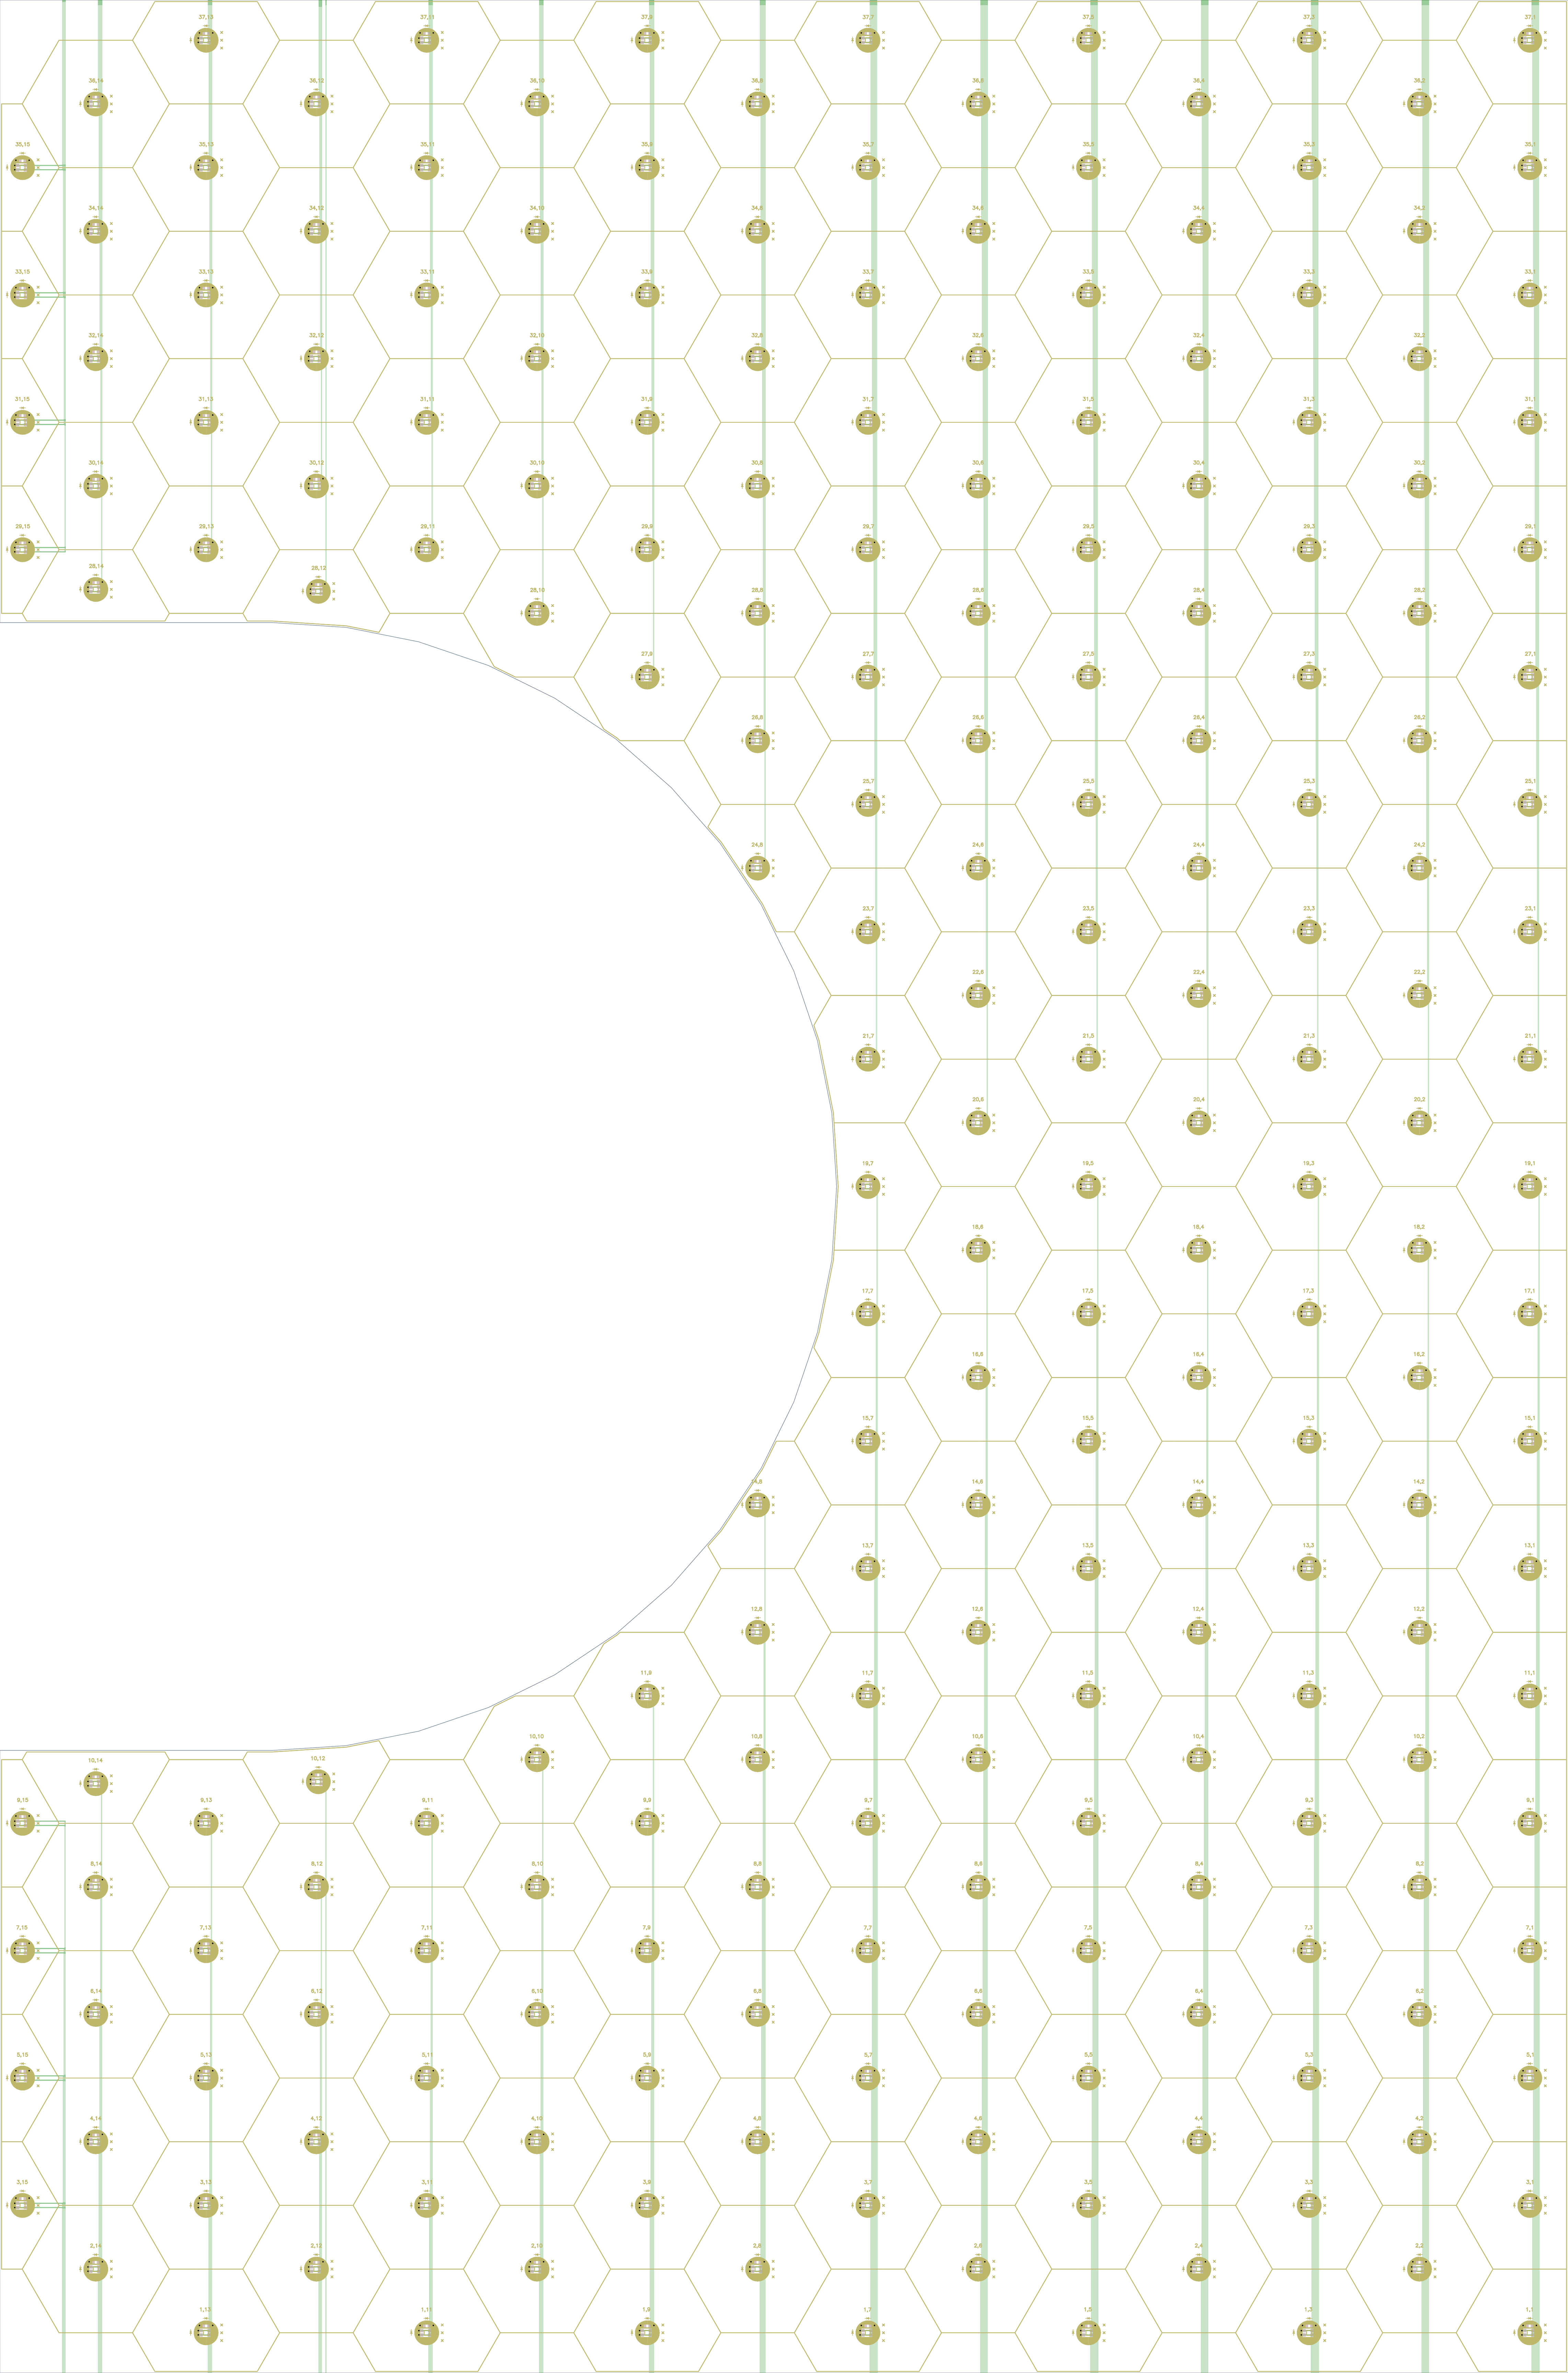

In [370]:
# to view the pdf in the jupyter notebook (without having to switch back and forth with another application),
# use the "wand" package, which in turn requires another library called imagemagick.
# pip install wand
# pip install imagemagick
from wand.image import Image as WImage
img = WImage(filename='R_0/R_0_preview_all.pdf')
img

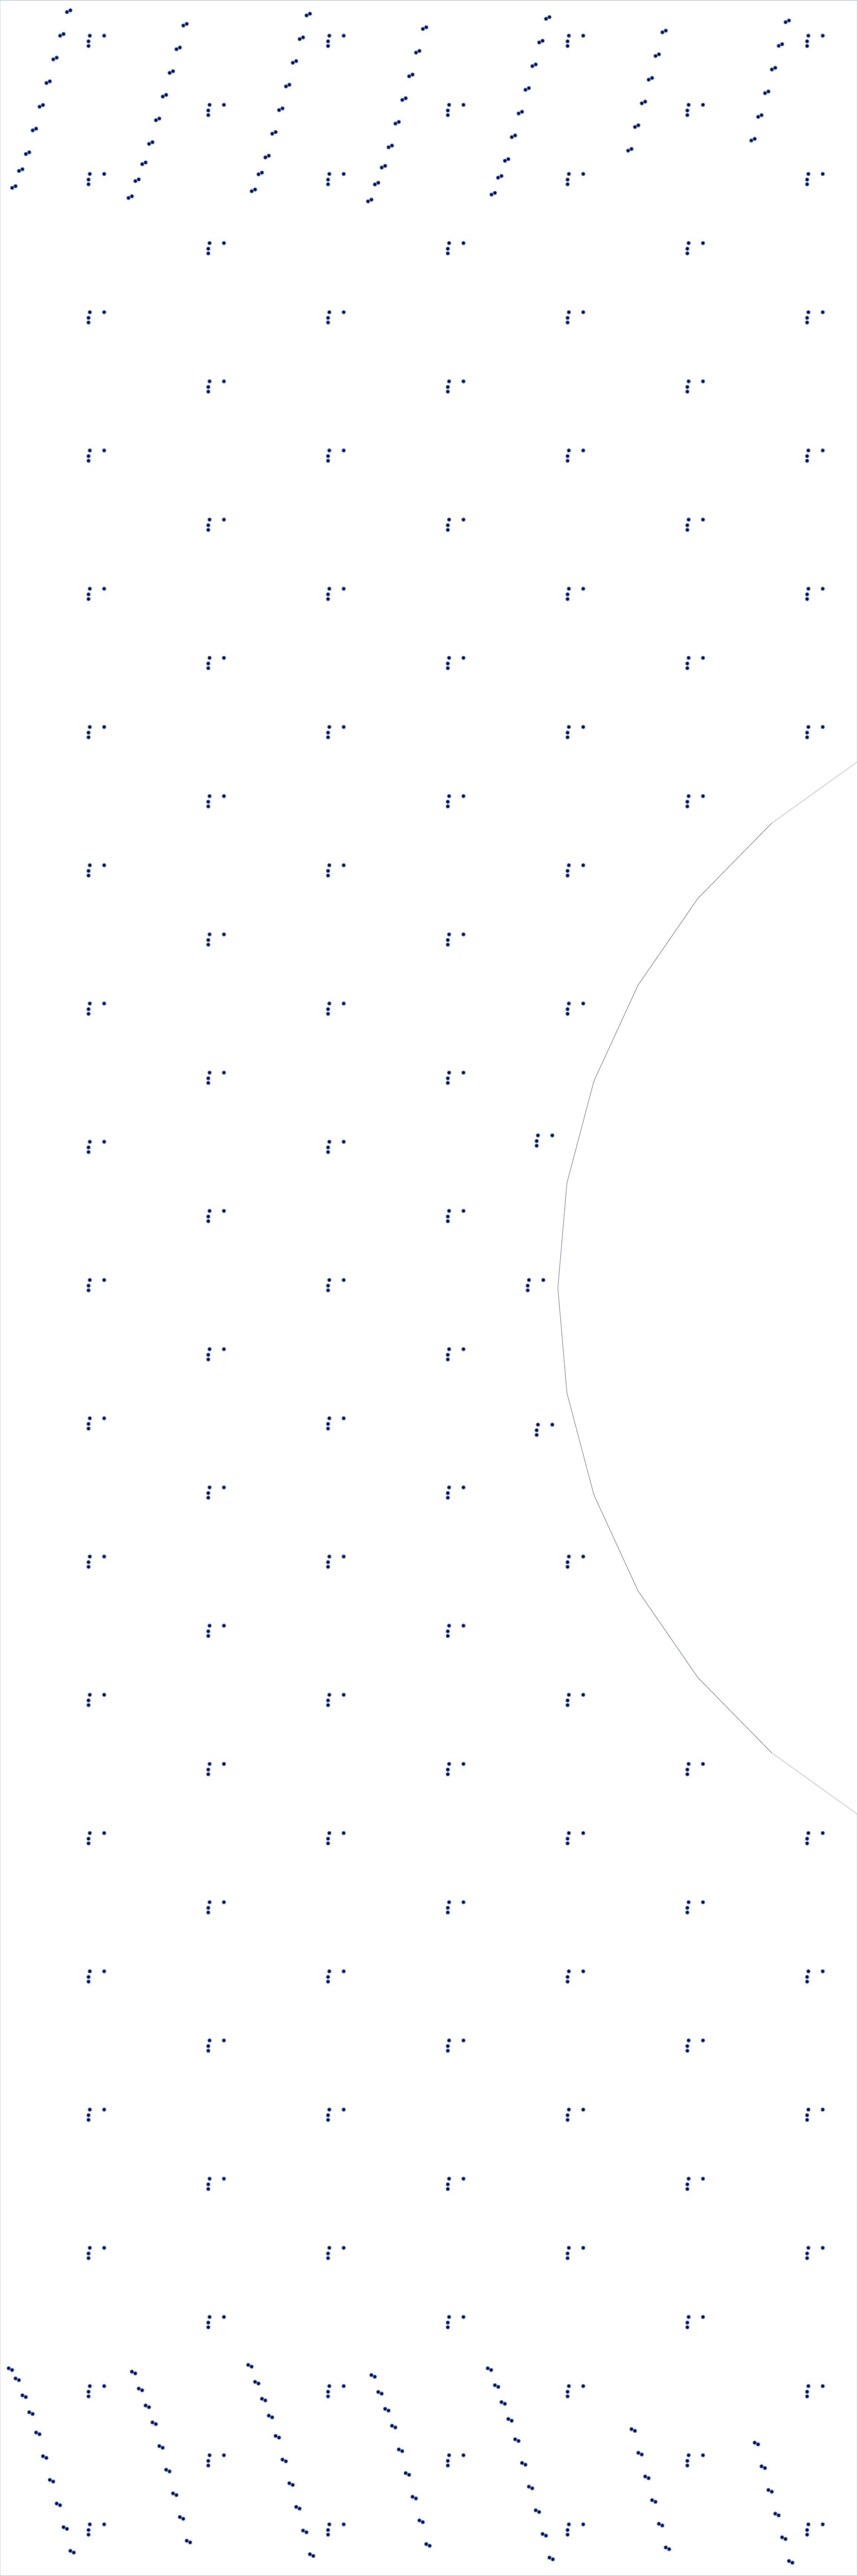

In [249]:
img = WImage(filename='mypcb/mypcb_preview_bot.pdf')
img